<a href="https://colab.research.google.com/github/herrerocjuancarlos/PySpark/blob/main/Predict%20House%20Price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Library



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pyspark
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

In [ ]:
import os
import pandas as pd
import numpy as np

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col

from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

In [ ]:
!pip install opendatasets
import opendatasets as od

In [ ]:
# Visualization
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 400)

from matplotlib import rcParams
sns.set(context='notebook', style='whitegrid', rc={'figure.figsize': (18,4)})
rcParams['figure.figsize'] = 18,4

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:
# setting random seed for notebook reproducability
rnd_seed=23
np.random.seed=rnd_seed
np.random.set_state=rnd_seed

## 2. Creating the Spark Session

In [ ]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
appname = "California Housing"
# Se obtiene la sesión por si estuviera abierta previamente y se cierra
spark = SparkSession.builder.appName(appname).master("local[*]").getOrCreate()

# Se crea un contexto nuevo
#conf = SparkConf().setMaster("local[*]").setAppName(appname)
#sc = SparkContext(conf = conf)

spark
#sc

In [ ]:
sqlContext = SQLContext(spark.sparkContext)
sqlContext

/usr/local/lib/python3.11/dist-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [ ]:

!ls / -la
!ls "/content/drive/MyDrive/"
BASEPATH = "/content/drive/MyDrive/"


total 460
drwxr-xr-x   1 root root   4096 Mar 12 13:22 .
drwxr-xr-x   1 root root   4096 Mar 12 13:22 ..
lrwxrwxrwx   1 root root      7 Jun 27  2024 bin -> usr/bin
drwxr-xr-x   2 root root   4096 Apr 18  2022 boot
drwxr-xr-x   1 root root   4096 Mar 12 13:23 content
-rw-r--r--   1 root root   4332 Jul 10  2024 cuda-keyring_1.1-1_all.deb
drwxr-xr-x   1 root root   4096 Mar 10 13:42 datalab
drwxr-xr-x   5 root root    360 Mar 12 13:22 dev
-rwxr-xr-x   1 root root      0 Mar 12 13:22 .dockerenv
drwxr-xr-x   1 root root   4096 Mar 12 13:23 etc
drwxr-xr-x   2 root root   4096 Apr 18  2022 home
drwxr-xr-x   3 root root   4096 Mar 12 13:22 kaggle
lrwxrwxrwx   1 root root      7 Jun 27  2024 lib -> usr/lib
lrwxrwxrwx   1 root root      9 Jun 27  2024 lib32 -> usr/lib32
lrwxrwxrwx   1 root root      9 Jun 27  2024 lib64 -> usr/lib64
lrwxrwxrwx   1 root root     10 Jun 27  2024 libx32 -> usr/libx32
drwxr-xr-x   2 root root   4096 Jun 27  2024 media
drwxr-xr-x   2 root root   4096 Jun 27  2024 m

## 3. Load The Data From a File Into a Dataframe

In [ ]:
HOUSING_DATA = BASEPATH + 'train.csv'
print(HOUSING_DATA)

/content/drive/MyDrive/train.csv


In [ ]:
# Display all columns and their data types
HOUSING_DATA = spark.read.csv(HOUSING_DATA, header=True, inferSchema=True)
HOUSING_DATA.printSchema()

# Descriptive statistics for numerical features
HOUSING_DATA.describe().toPandas().transpose()

# Count of unique values per column
for col_name in HOUSING_DATA.columns:
    print(f"Column: {col_name}, Unique Count: {HOUSING_DATA.select(col_name).distinct().count()}")


# Identify numerical and categorical features
numerical_cols = [f.name for f in HOUSING_DATA.schema.fields if isinstance(f.dataType, (IntegerType, FloatType, DoubleType))]
categorical_cols = [f.name for f in HOUSING_DATA.schema.fields if isinstance(f.dataType, StringType)]


print("Numerical Columns:", numerical_cols)
print("Categorical Columns:", categorical_cols)

# Remove non-numerical columns and 'Id'
cols_to_drop = [col for col in HOUSING_DATA.columns if col not in numerical_cols or col == 'Id']

HOUSING_DATA = HOUSING_DATA.drop(*cols_to_drop)

#Show the resulting DataFrame
HOUSING_DATA.printSchema()


root
 |-- Id: integer (nullable = true)
 |-- MSSubClass: integer (nullable = true)
 |-- MSZoning: string (nullable = true)
 |-- LotFrontage: string (nullable = true)
 |-- LotArea: integer (nullable = true)
 |-- Street: string (nullable = true)
 |-- Alley: string (nullable = true)
 |-- LotShape: string (nullable = true)
 |-- LandContour: string (nullable = true)
 |-- Utilities: string (nullable = true)
 |-- LotConfig: string (nullable = true)
 |-- LandSlope: string (nullable = true)
 |-- Neighborhood: string (nullable = true)
 |-- Condition1: string (nullable = true)
 |-- Condition2: string (nullable = true)
 |-- BldgType: string (nullable = true)
 |-- HouseStyle: string (nullable = true)
 |-- OverallQual: integer (nullable = true)
 |-- OverallCond: integer (nullable = true)
 |-- YearBuilt: integer (nullable = true)
 |-- YearRemodAdd: integer (nullable = true)
 |-- RoofStyle: string (nullable = true)
 |-- RoofMatl: string (nullable = true)
 |-- Exterior1st: string (nullable = true)
 |--

,0,1,2,3,4
summary,count,mean,stddev,min,max
Id,1460,730.5,421.6100093688479,1,1460
MSSubClass,1460,56.897260273972606,42.30057099381045,20,190
MSZoning,1460,None,None,C (all),RM
LotFrontage,1460,70.04995836802665,24.28475177448321,100,NA
...,...,...,...,...,...
MoSold,1460,6.321917808219178,2.7036262083595113,1,12
YrSold,1460,2007.8157534246575,1.3280951205521145,2006,2010
SaleType,1460,None,None,COD,WD
SaleCondition,1460,None,None,Abnorml,Partial


Column: Id, Unique Count: 1460
Column: MSSubClass, Unique Count: 15
Column: MSZoning, Unique Count: 5
Column: LotFrontage, Unique Count: 111
Column: LotArea, Unique Count: 1073
Column: Street, Unique Count: 2
Column: Alley, Unique Count: 3
Column: LotShape, Unique Count: 4
Column: LandContour, Unique Count: 4
Column: Utilities, Unique Count: 2
Column: LotConfig, Unique Count: 5
Column: LandSlope, Unique Count: 3
Column: Neighborhood, Unique Count: 25
Column: Condition1, Unique Count: 9
Column: Condition2, Unique Count: 8
Column: BldgType, Unique Count: 5
Column: HouseStyle, Unique Count: 8
Column: OverallQual, Unique Count: 10
Column: OverallCond, Unique Count: 9
Column: YearBuilt, Unique Count: 112
Column: YearRemodAdd, Unique Count: 61
Column: RoofStyle, Unique Count: 6
Column: RoofMatl, Unique Count: 8
Column: Exterior1st, Unique Count: 15
Column: Exterior2nd, Unique Count: 16
Column: MasVnrType, Unique Count: 5
Column: MasVnrArea, Unique Count: 328
Column: ExterQual, Unique Count: 

Specifying the schema when loading data into a DataFrame will give better performance than schema inference.

In [ ]:
# prompt: Copiame el housing_data en uno nuevo llamado  housing_df

housing_df = HOUSING_DATA


In [ ]:
# Inspect first five rows
housing_df.take(5)

[Row(MSSubClass=60, LotArea=8450, OverallQual=7, OverallCond=5, YearBuilt=2003, YearRemodAdd=2003, BsmtFinSF1=706, BsmtFinSF2=0, BsmtUnfSF=150, TotalBsmtSF=856, 1stFlrSF=856, 2ndFlrSF=854, LowQualFinSF=0, GrLivArea=1710, BsmtFullBath=1, BsmtHalfBath=0, FullBath=2, HalfBath=1, BedroomAbvGr=3, KitchenAbvGr=1, TotRmsAbvGrd=8, Fireplaces=0, GarageCars=2, GarageArea=548, WoodDeckSF=0, OpenPorchSF=61, EnclosedPorch=0, 3SsnPorch=0, ScreenPorch=0, PoolArea=0, MiscVal=0, MoSold=2, YrSold=2008, SalePrice=208500),
 Row(MSSubClass=20, LotArea=9600, OverallQual=6, OverallCond=8, YearBuilt=1976, YearRemodAdd=1976, BsmtFinSF1=978, BsmtFinSF2=0, BsmtUnfSF=284, TotalBsmtSF=1262, 1stFlrSF=1262, 2ndFlrSF=0, LowQualFinSF=0, GrLivArea=1262, BsmtFullBath=0, BsmtHalfBath=1, FullBath=2, HalfBath=0, BedroomAbvGr=3, KitchenAbvGr=1, TotRmsAbvGrd=6, Fireplaces=1, GarageCars=2, GarageArea=460, WoodDeckSF=298, OpenPorchSF=0, EnclosedPorch=0, 3SsnPorch=0, ScreenPorch=0, PoolArea=0, MiscVal=0, MoSold=5, YrSold=2007, 

In [ ]:
# Show first five rows
housing_df.show(5)

+----------+-------+-----------+-----------+---------+------------+----------+----------+---------+-----------+--------+--------+------------+---------+------------+------------+--------+--------+------------+------------+------------+----------+----------+----------+----------+-----------+-------------+---------+-----------+--------+-------+------+------+---------+
|MSSubClass|LotArea|OverallQual|OverallCond|YearBuilt|YearRemodAdd|BsmtFinSF1|BsmtFinSF2|BsmtUnfSF|TotalBsmtSF|1stFlrSF|2ndFlrSF|LowQualFinSF|GrLivArea|BsmtFullBath|BsmtHalfBath|FullBath|HalfBath|BedroomAbvGr|KitchenAbvGr|TotRmsAbvGrd|Fireplaces|GarageCars|GarageArea|WoodDeckSF|OpenPorchSF|EnclosedPorch|3SsnPorch|ScreenPorch|PoolArea|MiscVal|MoSold|YrSold|SalePrice|
+----------+-------+-----------+-----------+---------+------------+----------+----------+---------+-----------+--------+--------+------------+---------+------------+------------+--------+--------+------------+------------+------------+----------+----------+-----

In [ ]:
# show the dataframe columns
housing_df.columns

['MSSubClass',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold',
 'SalePrice']

In [ ]:
# show the schema of the dataframe
housing_df.printSchema()

root
 |-- MSSubClass: integer (nullable = true)
 |-- LotArea: integer (nullable = true)
 |-- OverallQual: integer (nullable = true)
 |-- OverallCond: integer (nullable = true)
 |-- YearBuilt: integer (nullable = true)
 |-- YearRemodAdd: integer (nullable = true)
 |-- BsmtFinSF1: integer (nullable = true)
 |-- BsmtFinSF2: integer (nullable = true)
 |-- BsmtUnfSF: integer (nullable = true)
 |-- TotalBsmtSF: integer (nullable = true)
 |-- 1stFlrSF: integer (nullable = true)
 |-- 2ndFlrSF: integer (nullable = true)
 |-- LowQualFinSF: integer (nullable = true)
 |-- GrLivArea: integer (nullable = true)
 |-- BsmtFullBath: integer (nullable = true)
 |-- BsmtHalfBath: integer (nullable = true)
 |-- FullBath: integer (nullable = true)
 |-- HalfBath: integer (nullable = true)
 |-- BedroomAbvGr: integer (nullable = true)
 |-- KitchenAbvGr: integer (nullable = true)
 |-- TotRmsAbvGrd: integer (nullable = true)
 |-- Fireplaces: integer (nullable = true)
 |-- GarageCars: integer (nullable = true)
 |-

## 4. Data Exploration

In [ ]:
# prompt: # prompt: Como puedo ver el numero de valores perdidos por columnas de housing_df, solo muestrame aquellas columnas que tengan los valroes perdidos

# Check for missing values in each column and display columns with missing values
missing_values = housing_df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in housing_df.columns])
missing_values_df = missing_values.toPandas().transpose().rename(columns={0: "Missing Values"})
print(missing_values_df[missing_values_df["Missing Values"] > 0])


Empty DataFrame
Columns: [Missing Values]
Index: []


In [ ]:
len(housing_df.columns)#Tenemos 34 variables

34

In [ ]:
housing_df.show(5)

+----------+-------+-----------+-----------+---------+------------+----------+----------+---------+-----------+--------+--------+------------+---------+------------+------------+--------+--------+------------+------------+------------+----------+----------+----------+----------+-----------+-------------+---------+-----------+--------+-------+------+------+---------+
|MSSubClass|LotArea|OverallQual|OverallCond|YearBuilt|YearRemodAdd|BsmtFinSF1|BsmtFinSF2|BsmtUnfSF|TotalBsmtSF|1stFlrSF|2ndFlrSF|LowQualFinSF|GrLivArea|BsmtFullBath|BsmtHalfBath|FullBath|HalfBath|BedroomAbvGr|KitchenAbvGr|TotRmsAbvGrd|Fireplaces|GarageCars|GarageArea|WoodDeckSF|OpenPorchSF|EnclosedPorch|3SsnPorch|ScreenPorch|PoolArea|MiscVal|MoSold|YrSold|SalePrice|
+----------+-------+-----------+-----------+---------+------------+----------+----------+---------+-----------+--------+--------+------------+---------+------------+------------+--------+--------+------------+------------+------------+----------+----------+-----

In [ ]:
# run a sample selection
housing_df.select('saleprice','LotArea').show(10)

+---------+-------+
|saleprice|LotArea|
+---------+-------+
|   208500|   8450|
|   181500|   9600|
|   223500|  11250|
|   140000|   9550|
|   250000|  14260|
|   143000|  14115|
|   307000|  10084|
|   200000|  10382|
|   129900|   6120|
|   118000|   7420|
+---------+-------+
only showing top 10 rows



\### 4.1 Eliminar valores atípicos

<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='SalePrice', ylabel='Count'>

Text(0.5, 1.0, 'Distribution of SalePrice')

Text(0.5, 0, 'SalePrice')

Text(0, 0.5, 'Frequency')

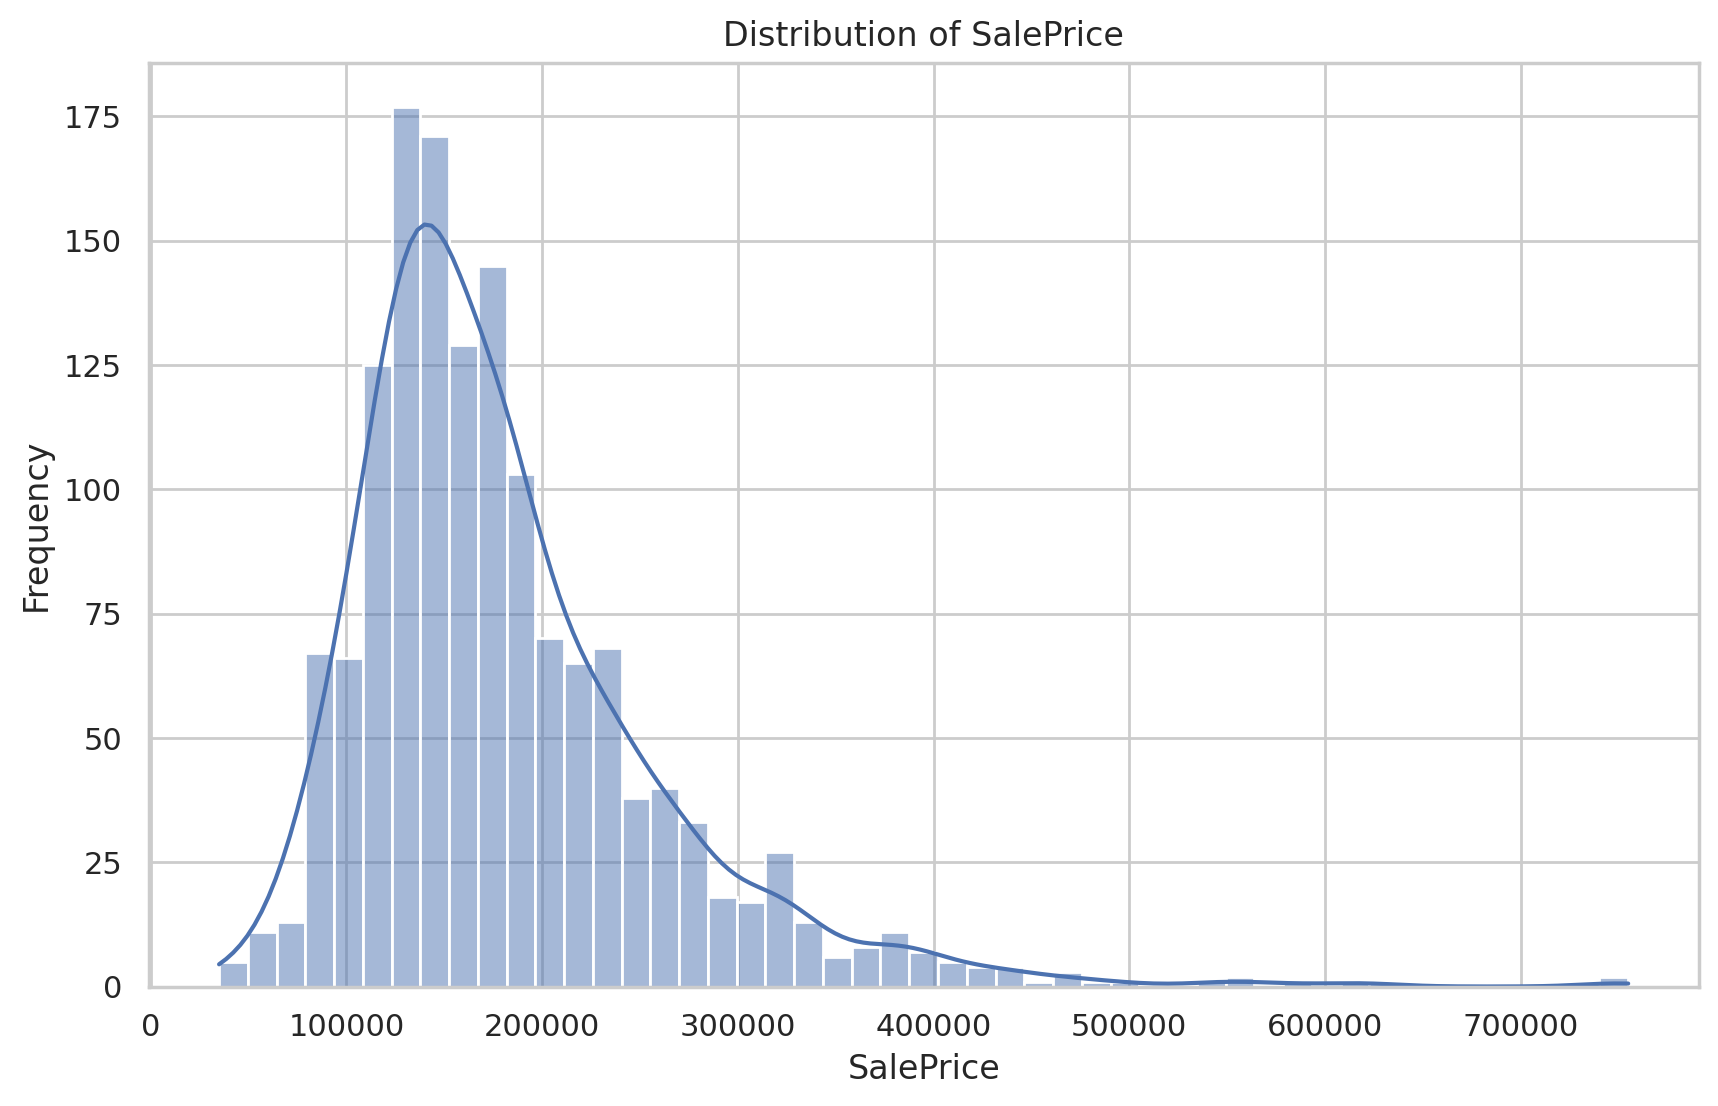

In [ ]:
housing_pd = housing_df.toPandas()

# Create the plot
plt.figure(figsize=(10, 6))
sns.histplot(housing_pd['SalePrice'], kde=True)
plt.title('Distribution of SalePrice')
plt.xlabel('SalePrice')
plt.ylabel('Frequency')
plt.show()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Skewness of SalePrice: 1.880940746034036
Kurtosis of SalePrice: 6.509812011089439


<Figure size 800x600 with 0 Axes>

<Axes: ylabel='SalePrice'>

Text(0.5, 1.0, 'Boxplot of SalePrice')

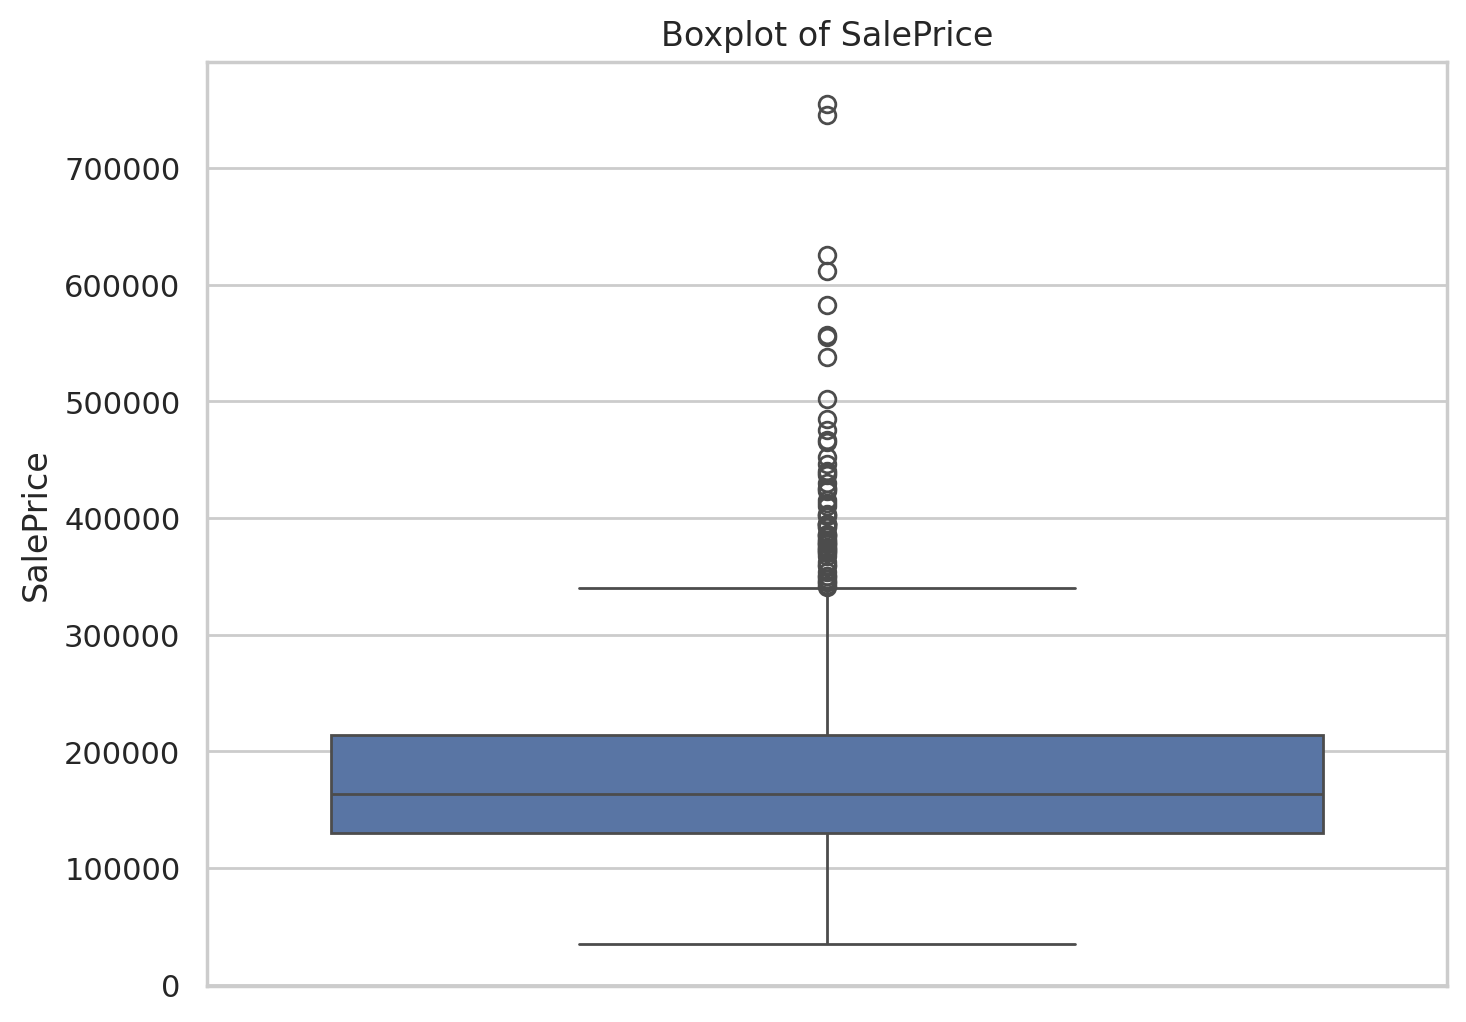

In [ ]:
# Calculate descriptive statistics for 'SalePrice'
sale_price_stats = housing_pd['SalePrice'].describe()
print(sale_price_stats)

# Calculate skewness and kurtosis
skewness = stats.skew(housing_pd['SalePrice'])
kurtosis = stats.kurtosis(housing_pd['SalePrice'])

print(f"\nSkewness of SalePrice: {skewness}")
print(f"Kurtosis of SalePrice: {kurtosis}")

#Further analysis (optional):
# Boxplot to visualize potential outliers
plt.figure(figsize=(8, 6))
sns.boxplot(y=housing_pd['SalePrice'])
plt.title('Boxplot of SalePrice')
plt.show()

In [ ]:
# Method 1: Removing outliers based on a threshold (e.g., values above 500000)
housing_pd_filtered = housing_pd[housing_pd['SalePrice'] <= 500000]

# Method 2: Removing outliers using IQR (Interquartile Range)
Q1 = housing_pd['SalePrice'].quantile(0.25)
Q3 = housing_pd['SalePrice'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
housing_pd_filtered_iqr = housing_pd[~((housing_pd['SalePrice'] < lower_bound) | (housing_pd['SalePrice'] > upper_bound))]


# Convert the filtered Pandas DataFrame back to a Spark DataFrame
housing_df_filtered = spark.createDataFrame(housing_pd_filtered)
housing_df_filtered_iqr = spark.createDataFrame(housing_pd_filtered_iqr)

# Now you can use 'housing_df_filtered' or 'housing_df_filtered_iqr' for your analysis.
# Example: Display the shape of the filtered DataFrame
print("Shape of the filtered DataFrame (threshold):", (housing_df_filtered.count(), len(housing_df_filtered.columns)))
print("Shape of the filtered DataFrame (IQR):", (housing_df_filtered_iqr.count(), len(housing_df_filtered_iqr.columns)))

Shape of the filtered DataFrame (threshold): (1451, 34)
Shape of the filtered DataFrame (IQR): (1399, 34)


Primer filtrado para reducir aquellos valores atípicos

In [ ]:
import pandas as pd

# Assuming 'housing_pd' is your Pandas DataFrame
# Convert relevant columns to numeric if they are not already
numeric_cols = housing_pd.select_dtypes(include=np.number).columns

# Calculate the correlation between each numeric variable and 'SalePrice'
correlation_with_price = housing_pd[numeric_cols].corrwith(housing_pd['SalePrice'])

# Create a DataFrame from the correlations
correlation_df = pd.DataFrame({'Variable': correlation_with_price.index,
                              'Correlation with SalePrice': correlation_with_price.values})

# Sort the DataFrame by correlation
correlation_df = correlation_df.sort_values(by='Correlation with SalePrice', ascending=False)


# Display the correlations
correlation_df

,Variable,Correlation with SalePrice
33,SalePrice,1.000000
2,OverallQual,0.790982
13,GrLivArea,0.708624
22,GarageCars,0.640409
23,GarageArea,0.623431
9,TotalBsmtSF,0.613581
10,1stFlrSF,0.605852
16,FullBath,0.560664
20,TotRmsAbvGrd,0.533723
4,YearBuilt,0.522897


<Figure size 1200x600 with 0 Axes>

<ipython-input-26-843e4725eec1>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Correlation with SalePrice', y='Variable', data=correlation_df, palette='coolwarm')


<Axes: xlabel='Correlation with SalePrice', ylabel='Variable'>

Text(0.5, 0, 'Correlación con SalePrice')

Text(0, 0.5, 'Variables')

Text(0.5, 1.0, 'Correlación de cada variable con SalePrice')

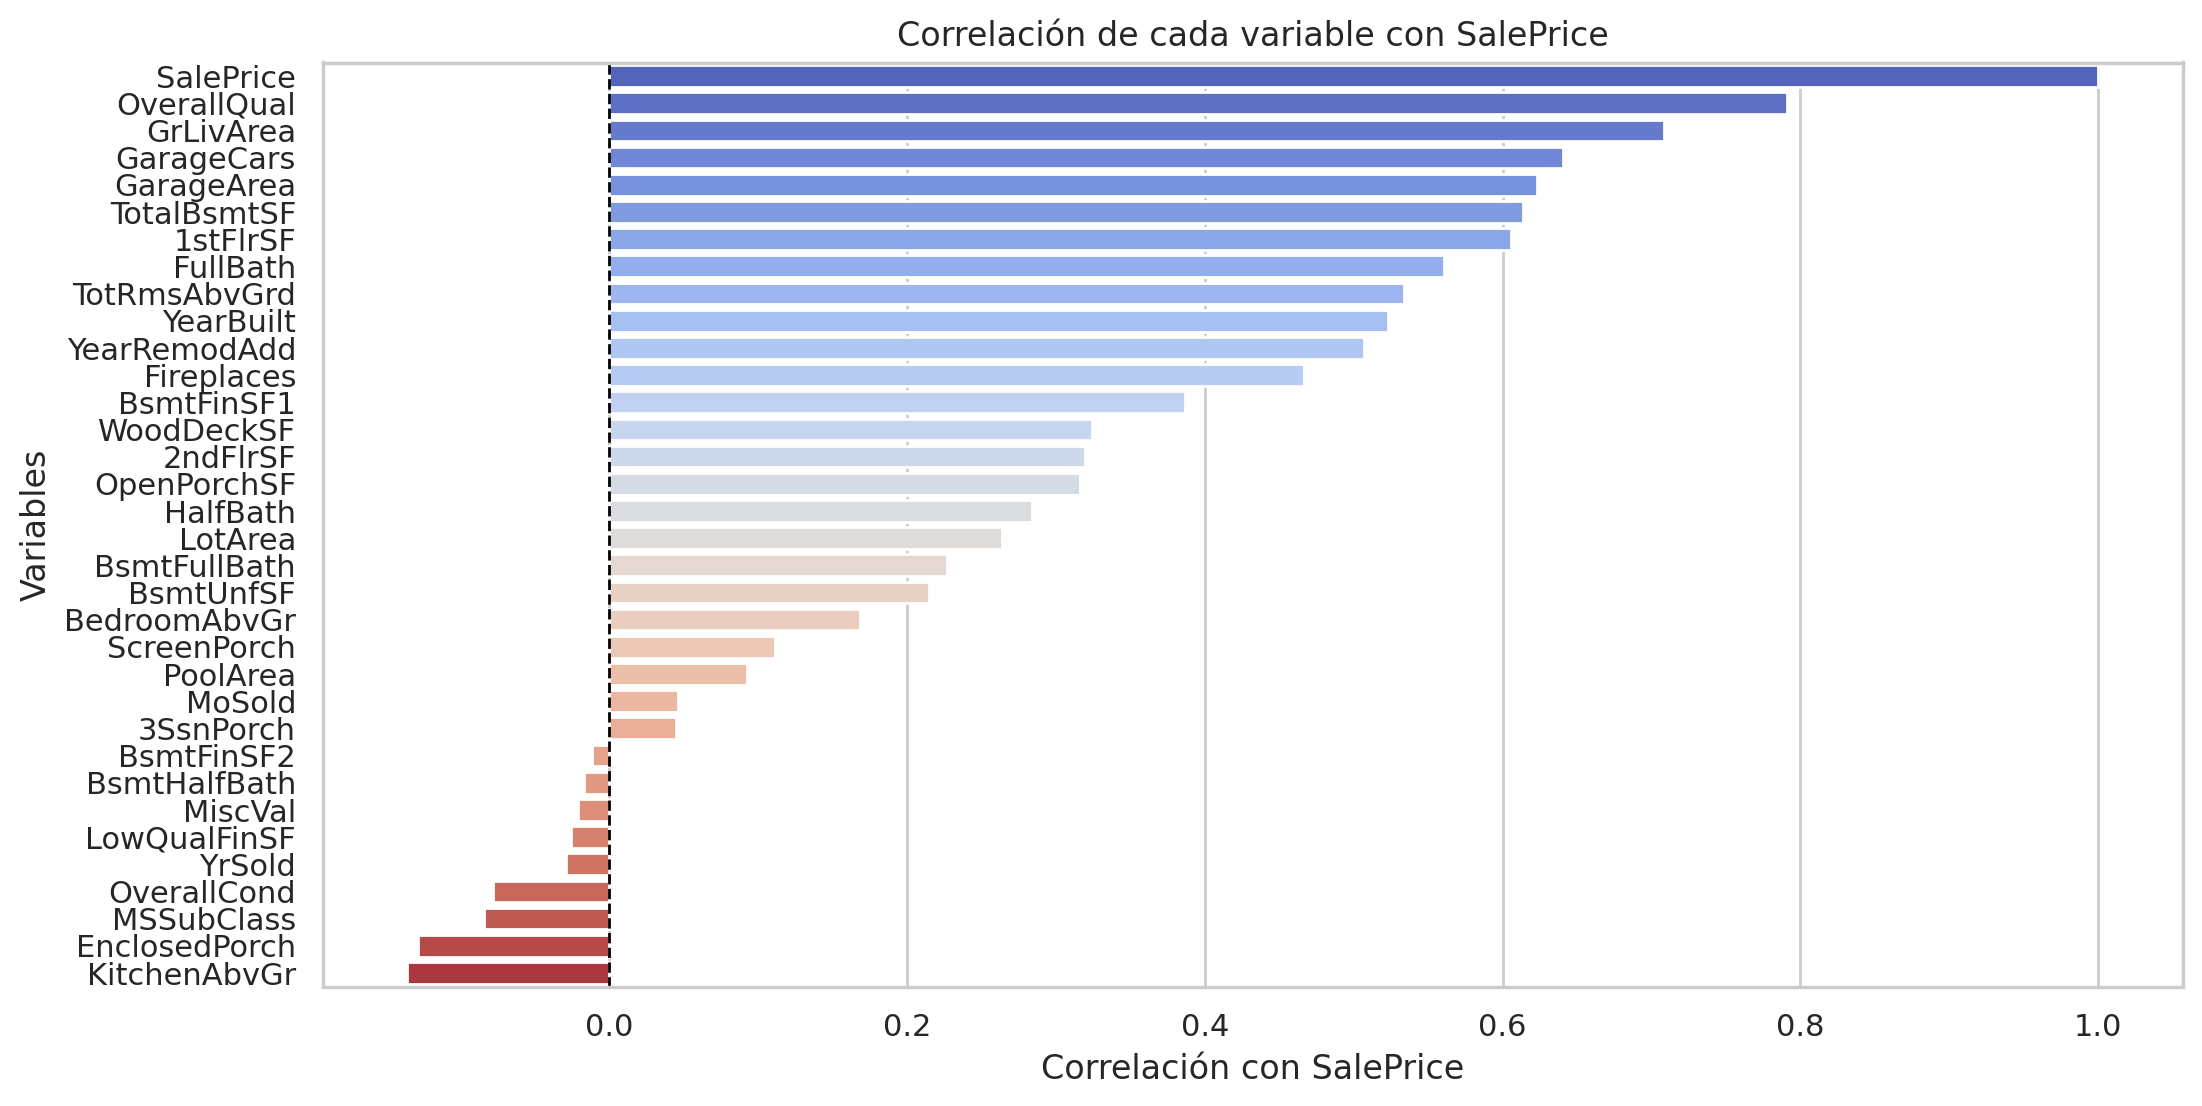

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Calcular la correlación
numeric_cols = housing_pd.select_dtypes(include=np.number).columns
correlation_with_price = housing_pd[numeric_cols].corrwith(housing_pd['SalePrice'])

# Convertir en DataFrame y ordenar
correlation_df = pd.DataFrame({'Variable': correlation_with_price.index,
                               'Correlation with SalePrice': correlation_with_price.values})
correlation_df = correlation_df.sort_values(by='Correlation with SalePrice', ascending=False)

# 📊 Crear el gráfico de barras
plt.figure(figsize=(12, 6))
sns.barplot(x='Correlation with SalePrice', y='Variable', data=correlation_df, palette='coolwarm')

# Etiquetas y título
plt.xlabel('Correlación con SalePrice')
plt.ylabel('Variables')
plt.title('Correlación de cada variable con SalePrice')
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)  # Línea vertical en 0 para ver qué es positivo/negativo
plt.show()


In [ ]:
from pyspark.sql.types import *

# Create a list to store the variable type counts
variable_type_counts = []

# Iterate through the columns of the DataFrame
for col_name in housing_df.columns:
    # Get the data type of the current column
    data_type = housing_df.schema[col_name].dataType

    # Convert the data type to a string representation
    data_type_str = str(data_type)

    # Add the variable type and its count to the list
    variable_type_counts.append((data_type_str, 1))

# Create a Pandas DataFrame from the variable type counts
import pandas as pd
variable_type_counts_df = pd.DataFrame(variable_type_counts, columns=['Variable Type', 'Count'])

# Group the Pandas DataFrame by variable type and sum the counts
grouped_counts = variable_type_counts_df.groupby('Variable Type')['Count'].sum()

# Print the grouped variable type counts
grouped_counts


,Count
Variable Type,
IntegerType(),34


In [ ]:
housing_df.show(15)

+----------+-------+-----------+-----------+---------+------------+----------+----------+---------+-----------+--------+--------+------------+---------+------------+------------+--------+--------+------------+------------+------------+----------+----------+----------+----------+-----------+-------------+---------+-----------+--------+-------+------+------+---------+
|MSSubClass|LotArea|OverallQual|OverallCond|YearBuilt|YearRemodAdd|BsmtFinSF1|BsmtFinSF2|BsmtUnfSF|TotalBsmtSF|1stFlrSF|2ndFlrSF|LowQualFinSF|GrLivArea|BsmtFullBath|BsmtHalfBath|FullBath|HalfBath|BedroomAbvGr|KitchenAbvGr|TotRmsAbvGrd|Fireplaces|GarageCars|GarageArea|WoodDeckSF|OpenPorchSF|EnclosedPorch|3SsnPorch|ScreenPorch|PoolArea|MiscVal|MoSold|YrSold|SalePrice|
+----------+-------+-----------+-----------+---------+------------+----------+----------+---------+-----------+--------+--------+------------+---------+------------+------------+--------+--------+------------+------------+------------+----------+----------+-----

### 6.1 Feature Extraction

Now that we have re-ordered the data, we're ready to normalize the data. We will choose the features to be normalized.

In [ ]:
housing_df.show(5)

+----------+-------+-----------+-----------+---------+------------+----------+----------+---------+-----------+--------+--------+------------+---------+------------+------------+--------+--------+------------+------------+------------+----------+----------+----------+----------+-----------+-------------+---------+-----------+--------+-------+------+------+---------+
|MSSubClass|LotArea|OverallQual|OverallCond|YearBuilt|YearRemodAdd|BsmtFinSF1|BsmtFinSF2|BsmtUnfSF|TotalBsmtSF|1stFlrSF|2ndFlrSF|LowQualFinSF|GrLivArea|BsmtFullBath|BsmtHalfBath|FullBath|HalfBath|BedroomAbvGr|KitchenAbvGr|TotRmsAbvGrd|Fireplaces|GarageCars|GarageArea|WoodDeckSF|OpenPorchSF|EnclosedPorch|3SsnPorch|ScreenPorch|PoolArea|MiscVal|MoSold|YrSold|SalePrice|
+----------+-------+-----------+-----------+---------+------------+----------+----------+---------+-----------+--------+--------+------------+---------+------------+------------+--------+--------+------------+------------+------------+----------+----------+-----

In [ ]:
# Assuming 'housing_df_filtered_iqr' is your DataFrame (you can replace it with 'housing_df_filtered' if needed).
featureCols = housing_df.columns
featureCols.remove('SalePrice')

# Print the feature columns
featureCols


['MSSubClass',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold']

In [ ]:
assembled_df = VectorAssembler(inputCols=featureCols, outputCol="features")

In [ ]:
assembled_df

VectorAssembler_1c554f290db5

All the features have transformed into a Dense Vector.

### 6.2 Standardization

Next, we can finally scale the data using `StandardScaler`. The input columns are the `features`, and the output column with the rescaled that will be included in the scaled_df will be named `"features_scaled"`:

In [ ]:
# Initialize the `standardScaler`
standardScaler = StandardScaler(inputCol="features", outputCol="features_scaled")

In [ ]:
# Fit and transform using VectorAssembler to create a new DataFrame
assembled_data = assembled_df.transform(housing_df)

# Now fit the StandardScaler to the new DataFrame containing the assembled features
scaled_df = standardScaler.fit(assembled_data).transform(assembled_data)

In [ ]:
# Inspect the result
scaled_df.select("features", "features_scaled").show(10, truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|features                                                                                                                                                                      |features_scaled                                                                                            

In [ ]:
scaled_df.select("features_scaled").show(10, truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|features_scaled                                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [ ]:
import pandas as pd
l = scaled_df.select('features_scaled').collect()


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.ml.linalg import Vectors
from pyspark.sql.types import ArrayType, DoubleType

# Create a SparkSession
spark = SparkSession.builder \
    .appName("Vector Conversion") \
    .getOrCreate()

# Sample DataFrame with a dense vector column
data = [(Vectors.dense([1.0, 2.0, 3.0]),),
        (Vectors.dense([4.0, 5.0, 6.0]),)]
df = spark.createDataFrame(data, ["dense_vector"])

# Define a user-defined function (UDF) to convert dense vector to normal vector
def to_normal_vector(dense_vector):
    return list(dense_vector)

# Register the UDF
to_normal_vector_udf = udf(to_normal_vector, ArrayType(DoubleType()))

# Apply the UDF to the DataFrame
df = df.withColumn("normal_vector", to_normal_vector_udf("dense_vector"))

# Show the DataFrame
l2 = df.select('normal_vector')
l2

DataFrame[normal_vector: array<double>]

## 7. Building A Machine Learning Model With Spark ML

With all the preprocessing done, it's finally time to start building our Linear Regression model! Just like always, we first need to split the data into training and test sets. Luckily, this is no issue with the `randomSplit()` method:

### 7.1 Partitioning the dataset

In [ ]:
# Split the data into train and test sets
train_data, test_data = scaled_df.randomSplit([.8,.2], seed=rnd_seed)
train_data

DataFrame[MSSubClass: int, LotArea: int, OverallQual: int, OverallCond: int, YearBuilt: int, YearRemodAdd: int, BsmtFinSF1: int, BsmtFinSF2: int, BsmtUnfSF: int, TotalBsmtSF: int, 1stFlrSF: int, 2ndFlrSF: int, LowQualFinSF: int, GrLivArea: int, BsmtFullBath: int, BsmtHalfBath: int, FullBath: int, HalfBath: int, BedroomAbvGr: int, KitchenAbvGr: int, TotRmsAbvGrd: int, Fireplaces: int, GarageCars: int, GarageArea: int, WoodDeckSF: int, OpenPorchSF: int, EnclosedPorch: int, 3SsnPorch: int, ScreenPorch: int, PoolArea: int, MiscVal: int, MoSold: int, YrSold: int, SalePrice: int, features: vector, features_scaled: vector]

In [ ]:
train_data.columns

['MSSubClass',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold',
 'SalePrice',
 'features',
 'features_scaled']

In [ ]:
# Initialize `lr`
lr = (LinearRegression(featuresCol='features_scaled', labelCol="SalePrice", predictionCol='predsaleprice',
                               maxIter=10, regParam=0.3, elasticNetParam=0.8, standardization=False))

### 7.2. Creating and Evaluating a Linear Regression Model

Create a Linear regression model from the train dataset partition. And with our model in place, we can generate predictions for our test data: use the `transform()` method to predict the labels for our `test_data`. Then, we can use RDD operations to extract the predictions as well as the true labels from the DataFrame.

#### 7.2.1 Create an ElasticNet model:

ElasticNet is a linear regression model trained with L1 and L2 prior as regularizer. This combination allows for learning a sparse model where few of the weights are non-zero like Lasso, while still maintaining the regularization properties of Ridge. We control the convex combination of L1 and L2 using the l1_ratio parameter.

Elastic-net is useful when there are multiple features which are correlated with one another. Lasso is likely to pick one of these at random, while elastic-net is likely to pick both.

A practical advantage of trading-off between Lasso and Ridge is it allows Elastic-Net to inherit some of Ridge’s stability under rotation.

The objective function to minimize is in this case:
\begin{align}
min_w\frac{1}{2n_{samples}}{\parallel{X_w - y}\parallel}^2_2 + \alpha\lambda{\parallel{X_w - y}\parallel}_1 + \frac{\alpha(1-\lambda)}{2}{\parallel{w}\parallel}^2_2
\end{align}

http://scikit-learn.org/stable/modules/linear_model.html#elastic-net

#### 7.2.2 Inspect the Model Co-efficients

In [ ]:
# Fit the data to the model
linearModel = lr.fit(train_data)

In [ ]:
# Coefficients for the model
linearModel.coefficients

DenseVector([-5841.4475, 4788.2531, 26938.1798, 5531.9041, 5985.7602, 4355.3453, 5296.9477, -1241.0038, 0.0, 5618.4449, 8467.8927, 9400.2091, -365.8554, 10377.121, 4225.6748, 304.2625, 4445.8801, 915.9613, -6133.9064, -3596.8384, 7626.3847, 3384.2648, 6558.582, 3867.577, 4054.5716, -1325.1078, 283.6655, 307.0977, 3032.6655, -2489.1328, -369.0871, 0.0, -474.1945])

In [ ]:
featureCols

['MSSubClass',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold']

In [ ]:
# Intercept for the model
linearModel.intercept

-175466.6237442154

In [ ]:
coeff_df = pd.DataFrame({"Feature": ["Intercept"] + featureCols, "Co-efficients": np.insert(linearModel.coefficients.toArray(), 0, linearModel.intercept)})
coeff_df = coeff_df[["Feature", "Co-efficients"]]

In [ ]:
coeff_df

,Feature,Co-efficients
0,Intercept,-175466.623744
1,MSSubClass,-5841.447489
2,LotArea,4788.253112
3,OverallQual,26938.179838
4,OverallCond,5531.904073
5,YearBuilt,5985.760205
6,YearRemodAdd,4355.345313
7,BsmtFinSF1,5296.947706
8,BsmtFinSF2,-1241.003762
9,BsmtUnfSF,0.000000


#### 7.2.3 Generating Predictions

In [ ]:
# Generate predictions
predictions = linearModel.transform(test_data)

In [ ]:
# Extract the predictions and the "known" correct labels
predandlabels = predictions.select("predSalePrice", "SalePrice")

In [ ]:
predandlabels.show()

+------------------+---------+
|     predSalePrice|SalePrice|
+------------------+---------+
|203310.40543011966|   159895|
| 87981.87263366318|   107900|
| 83720.17085014627|   115000|
|118499.90204070258|   123500|
|  95996.4005093943|   120500|
|134855.71367243404|   136500|
|147545.47729377385|   176000|
| 72949.85436792829|   109900|
| 134925.0632618388|   123000|
|  142763.431223366|   129000|
|132159.28912500158|   120000|
| 183202.4630624117|   149700|
| 161952.0015196746|   141000|
| 87116.24619200762|   110000|
|115425.55404992535|   130000|
|129574.79002558853|   109000|
|134293.57903229474|   132500|
|118576.13328320411|   141000|
|150909.37396788044|   132000|
| 89394.89089985873|   123600|
+------------------+---------+
only showing top 20 rows



#### 7.2.4 Inspect the Metrics

Looking at predicted values is one thing, but another and better thing is looking at some metrics to get a better idea of how good your model actually is.

**Using the `LinearRegressionModel.summary` attribute:**

Next, we can also use the `summary` attribute to pull up the `rootMeanSquaredError` and the `r2`.

In [ ]:
# Get the RMSE
print("RMSE: {0}".format(linearModel.summary.rootMeanSquaredError))

RMSE: 37042.08909506339


In [ ]:
print("MAE: {0}".format(linearModel.summary.meanAbsoluteError))

MAE: 22181.220497184804


In [ ]:
# Get the R2
print("R2: {0}".format(linearModel.summary.r2))

R2: 0.7942561160467437


+ The RMSE measures how much error there is between two datasets comparing a predicted value and an observed or known value. The smaller an RMSE value, the closer predicted and observed values are.

+ The R2 ("R squared") or the coefficient of determination is a measure that shows how close the data are to the fitted regression line. This score will always be between 0 and a 100% (or 0 to 1 in this case), where 0% indicates that the model explains none of the variability of the response data around its mean, and 100% indicates the opposite: it explains all the variability. That means that, in general, the higher the R-squared, the better the model fits our data.

**Using the RegressionEvaluator from pyspark.ml package:**

In [ ]:
evaluator = RegressionEvaluator(predictionCol="predSalePrice", labelCol='SalePrice', metricName='rmse')
print("RMSE: {0}".format(evaluator.evaluate(predandlabels)))

RMSE: 26434.639918914538


In [ ]:
evaluator = RegressionEvaluator(predictionCol="predSalePrice", labelCol='SalePrice', metricName='mae')
print("MAE: {0}".format(evaluator.evaluate(predandlabels)))

MAE: 19913.898217763526


In [ ]:
evaluator = RegressionEvaluator(predictionCol="predSalePrice", labelCol='SalePrice', metricName='r2')
print("R2: {0}".format(evaluator.evaluate(predandlabels)))

R2: 0.8594721963487613


**Using the RegressionMetrics from pyspark.mllib package:**

In [ ]:
# mllib is old so the methods are available in rdd
metrics = RegressionMetrics(predandlabels.rdd)

/usr/local/lib/python3.11/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


There's definitely some improvements needed to our model! If we want to continue with this model, we can play around with the parameters that we passed to your model, the variables that we included in your original DataFrame.

### 7.3 Creating and Evaluating a Random Forest Model


#### 7.3.1 Training the RF model

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator

# https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.regression.RandomForestRegressor.html
rf = RandomForestRegressor(numTrees=100, featuresCol='features_scaled', labelCol="SalePrice", predictionCol='predSalePrice')

# Train model.  This also runs the indexer.
model = rf.fit(train_data)

#rfModel = model.stages[1]
print(model)  # summary only

RandomForestRegressionModel: uid=RandomForestRegressor_1aceece6ba7a, numTrees=100, numFeatures=33


#### 7.3.2 Generating predictions and Inspect the Metrics

In [ ]:
def predict_rf_rmse(model, data):
  # Make predictions.
  predictions = model.transform(data)

  # Select example rows to display.
  #predictions.select("predmedhv", "medhv", "features_scaled").show(5)

  # Select (prediction, true label) and compute test error
  evaluator = RegressionEvaluator(labelCol="SalePrice", predictionCol='predSalePrice', metricName="rmse")
  rmse = evaluator.evaluate(predictions)

  return rmse

rmse = predict_rf_rmse(model, train_data)
print("Root Mean Squared Error (RMSE) on train data = %g" % rmse)

rmse = predict_rf_rmse(model, test_data)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on train data = 25433.2
Root Mean Squared Error (RMSE) on test data = 25243.7


          Feature  Importance
2     OverallQual    0.296571
22     GarageCars    0.144176
13      GrLivArea    0.127213
9     TotalBsmtSF    0.074303
4       YearBuilt    0.051078
23     GarageArea    0.046546
16       FullBath    0.042856
10       1stFlrSF    0.035268
6      BsmtFinSF1    0.034462
5    YearRemodAdd    0.025502
1         LotArea    0.025047
20   TotRmsAbvGrd    0.019935
21     Fireplaces    0.013214
11       2ndFlrSF    0.011633
25    OpenPorchSF    0.006266
18   BedroomAbvGr    0.005361
0      MSSubClass    0.005233
24     WoodDeckSF    0.004402
15   BsmtHalfBath    0.004223
31         MoSold    0.004112
8       BsmtUnfSF    0.004085
14   BsmtFullBath    0.003526
3     OverallCond    0.003262
29       PoolArea    0.003214
17       HalfBath    0.002181
19   KitchenAbvGr    0.002132
32         YrSold    0.001832
28    ScreenPorch    0.001049
7      BsmtFinSF2    0.000605
26  EnclosedPorch    0.000397
27      3SsnPorch    0.000228
12   LowQualFinSF    0.000062
30        

<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='Importance', ylabel='Feature'>

Text(0.5, 1.0, 'Feature Importances from Random Forest')

Text(0.5, 0, 'Importance')

Text(0, 0.5, 'Feature')

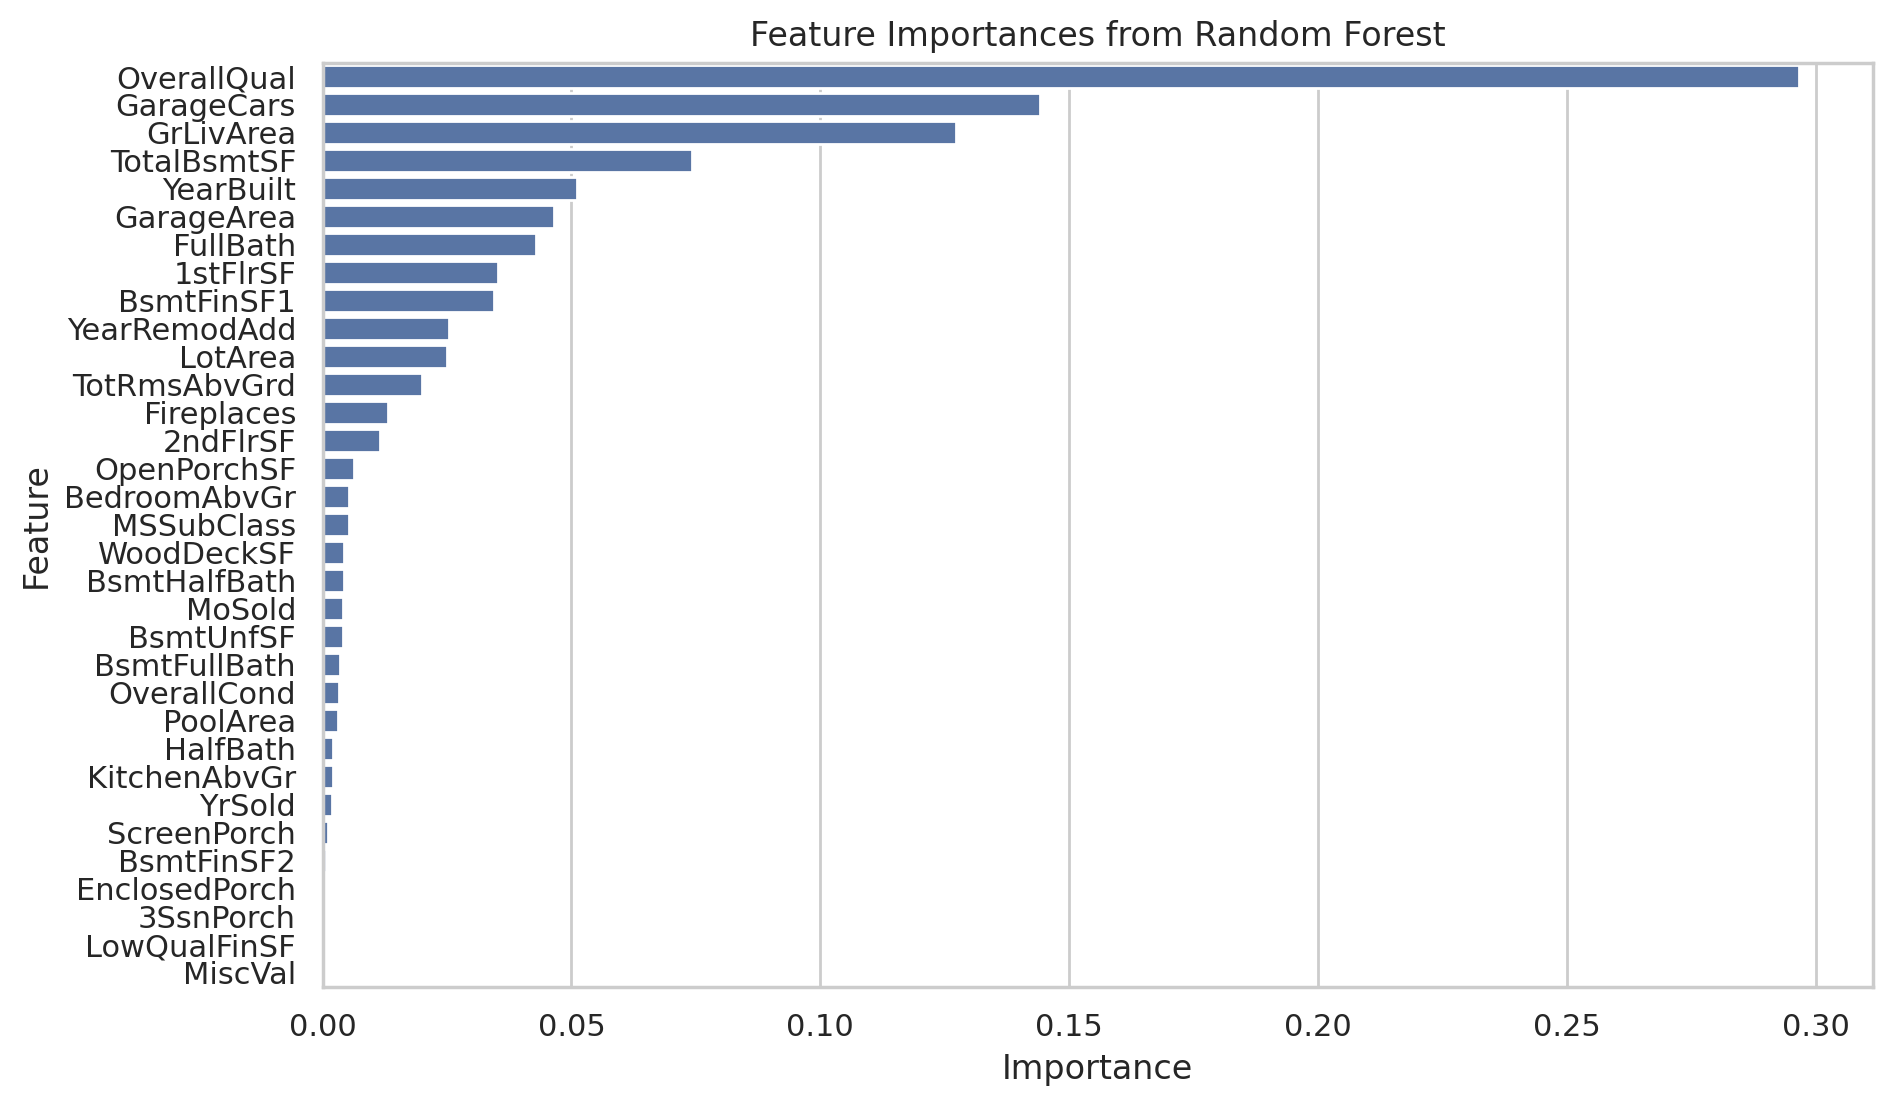

In [ ]:
# prompt: Del random forest que tengo arriba, me puedes dar codigo para interpretar el modelo o en su defecto aquellas variables que son mas importantes y o menos?

# Extract feature importances from the trained RandomForestRegressor model
feature_importances = model.featureImportances

# Get the feature names
feature_names = featureCols

# Create a DataFrame for better visualization
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances.toArray()
})

# Sort by importance
importances_df = importances_df.sort_values(by='Importance', ascending=False)

# Display the feature importances
print(importances_df)

# You can also plot the feature importances for better visualization
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importances_df)
plt.title('Feature Importances from Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


In [ ]:
spark.stop()